# Generalization: Model Validation

### 27th October 2015 Neil D. Lawrence

If we had to summarise the objectives of machine learning in one word, a very good candidate for that word would be *generalization*. What is generalization? From a human perspective it might be summarised as the ability to take lessons learned in one domain and apply them to another domain. If we accept the definition given in the first session for machine learning, 
$$
\text{data} + \text{model} \xrightarrow{\text{compute}} \text{prediction}
$$
then we see that without a model we can't generalise: we only have data. Data is fine for answering very specific questions, like "Who won the Olympic Marathon in 2012?", because we have that answer stored, however, we are not given the answer to many other questions. For example, Alan Turing was a formidable marathon runner, in 1946 he ran a time 2 hours 46 minutes (just under four minutes per kilometer, faster than most of the other [Endcliffe Park Run](http://www.parkrun.org.uk/sheffieldhallam/) runners can do 5 km). What is the probability he would have won an Olympics if one had been held in 1946?  
![Alan Turing, Times in the Times](http://www.turing.org.uk/turing/pi2/times2.gif)![Alan Turing running in 1946](http://www.turing.org.uk/turing/pi2/run.jpg)
<center>*Alan Turing, in 1946 he was only 11 minutes slower than the winner of the 1948 games. Would he have won a hypothetical games held in 1946? Source: [Alan Turing Internet Scrapbook](http://www.turing.org.uk/scrapbook/run.html).*</center>
To answer this question we need to generalize, but before we formalize the concept of generalization let's introduce some formal representation of what it means to generalize in machine learning.

### Expected Loss

Our objective function so far has been the negative log likelihood, which we have minimized (via the sum of squares error) to obtain our model. However, there is an alternative perspective on an objective function, that of a *loss function*. A loss function is a cost function associated with the penalty you might need to pay for a particular incorrect decision. One approach to machine learning involves specifying a loss function and considering how much a particular model is likely to cost us across its lifetime. We can represent this with an expectation. If our loss function is given as $L(y, x, \mathbf{w})$ for a particular model that predicts $y$ given $x$ and $\mathbf{w}$ then we are interested in minimizing the expected loss under the likely distribution of $y$ and $x$. To understand this formally we define the *true* distribution of the data samples, $y$, $x$. This is a very special distribution that we don't have access to very often, and to represent that we define it with a special letter 'P', $\mathbb{P}(y, x)$. If we genuinely pay $L(y, x, \mathbf{w})$ for every mistake we make, and the future test data is genuinely drawn from $\mathbb{P}(y, x)$ then we can define our expected loss, or risk, to be,
$$
R(\mathbf{w}) = \int L(y, x, \mathbf{w}) \mathbb{P}(y, x) \text{d}y \text{d}x.
$$
Of course, in practice, this value can't be computed *but* it serves as a reminder of what it is we are aiming to minimize and under certain circumstances it can be approximated.

### Sample Based Approximations

A sample based approximation to an expectation involves replacing the true expectation with a sum over samples from the distribution. 
$$
\int f(z) p(z) \text{d}y \text{d}z\approx \frac{1}{s}\sum_{i=1}^s f(z_i).
$$
if $\{z_i\}_{i=1}^s$ are a set of $s$ independent and identically distributed samples from the distribution $p(z)$. This approximation becomes better for larger $s$, although the *rate of convergence* to the true integral will be very dependent on the distribution $p(z)$ *and* the function $f(z)$. 

That said, this means we can approximate our true integral with the sum,
$$
R(\mathbf{w}) \approx \frac{1}{n}\sum_{i=1}^n L(y_i, x_i, \mathbf{w}),
$$
if $y_i$ and $x_i$ are independent samples from the true distribution $\mathbb{P}(y, x)$. Minimizing this sum directly is known as *empirical risk minimization*. The sum of squares error we have been using can be recovered for this case by considering a *squared loss*,
$$
L(y, x, \mathbf{w}) = (y-\mathbf{w}^\top\boldsymbol{\phi}(x))^2
$$
which gives an empirical risk of the form
$$
R(\mathbf{w}) \approx \frac{1}{n} \sum_{i=1}^n (y_i - \mathbf{w}^\top \boldsymbol{\phi}(x_i))^2
$$
which up to the constant $\frac{1}{n}$ is identical to the objective function we have been using so far.


### Estimating Risk through Validation

Unfortunately, minimising the empirial risk only guarantees something about our performance on the training data. If we don't have enough data for the approximation to the risk to be valid, then we can end up performing significantly worse on test data. Fortunately, we can also estimate the risk for test data through estimating the risk for unseen data.

The main trick here is to 'hold out' a portion of our data from training and use the models performance on that sub-set of the data as a proxy for the true risk. This data is known as 'validation' data. It contrasts with test data, because it's values are known at the model design time. However, in contrast to test data we don't use it to fit our model. This means that it doesn't exhibit the same bias that the empirical risk does when estimating the true risk.

In this lab we will explore techniques for model selection that make use of validation data. Data that isn't seen by the model in the learning (or fitting) phase, but is used to *validate* our choice of model from amongst the different designs we have selected.

In machine learning, we are looking to minimise the value of our objective function $E$ with respect to its parameters $\mathbf{w}$. We do this by considering our training data. We minimize the value of the objective function as it's observed at each training point. However we are really interested in how the model will perform on future data. For evaluating that we choose to *hold out* a portion of the data for evaluating the quality of the model.

We will review the different methods of model selection on the Olympics marathon data. Firstly we import the olympics data. 

In [1]:
import numpy as np
import pods
data = pods.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

We can plot them to check that they've loaded in correctly.


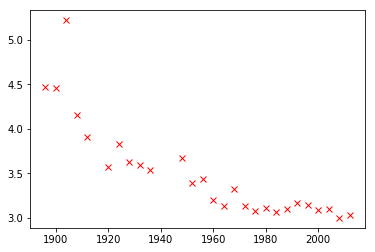

In [2]:
%matplotlib inline
import pylab as plt
plt.plot(x, y, 'rx')

## Hold Out Validation

The first thing we'll do is fit a standard linear model to the data. We recall from previous lectures and lab classes that to do this we need to solve the system
$$
\boldsymbol{\Phi}^\top \boldsymbol{\Phi} \mathbf{w} = \boldsymbol{\Phi}^\top \mathbf{y}
$$
for $\mathbf{w}$  and use the resulting vector to make predictions at the training points and test points,
$$
\mathbf{f} = \boldsymbol{\Phi} \mathbf{w}.
$$
The prediction function can be used to compute the objective function,
$$
E(\mathbf{w}) = \sum_{i}^n (y_i - \mathbf{w}^\top\phi(\mathbf{x}_i))^2
$$
by substituting in the prediction in vector form we have
$$
E(\mathbf{w}) =  (\mathbf{y} - \mathbf{f})^\top(\mathbf{y} - \mathbf{f})
$$

### Assignment Question 1

In this question you will construct some flexible general code for fitting linear models.

Create a python function that computes $\boldsymbol{\Phi}$ for the linear basis,
$$\boldsymbol{\Phi} = \begin{bmatrix} \mathbf{x} & \mathbf{1}\end{bmatrix}$$
Name your function `linear`. `Phi` should be in the form of a *design matrix* and `x` should be in the form of a `numpy` two dimensional array with $n$ rows and 1 column
Calls to your function should be in the following form:

```python
Phi = linear(x)
```

Create a python function that accepts, as arguments, a python function that defines a basis (like the one you've just created called `linear`) as well as a set of inputs and a vector of parameters. Your new python function should return a prediction. Name your function `prediction`. The return value `f` should be a two dimensional `numpy` array with $n$ rows and $1$ column, where $n$ is the number of data points. Calls to your function should be in the following form:

```python
f = prediction(w, x, linear)
```

Create a python function that computes the sum of squares objective function (or error function). It should accept your input data (or covariates) and target data (or response variables) and your parameter vector `w` as arguments. It should also accept a python function that represents the basis. Calls to your function should be in the following form:

```python
e = objective(w, x, y, linear)
```

Create a function that solves the linear system for the set of parameters that minimizes the sum of squares objective. It should accept input data, target data and a python function for the basis as the inputs. Calls to your function should be in the following form:

```python
w = fit(x, y, linear)
```

Fit a linear model to the olympic data using these functions and plot the resulting prediction between 1890 and 2020. Set the title of the plot to be the error of the fit on the *training data*.

*15 marks*

phi [[1.000e+00 1.896e+03]
 [1.000e+00 1.900e+03]
 [1.000e+00 1.904e+03]
 [1.000e+00 1.908e+03]
 [1.000e+00 1.912e+03]
 [1.000e+00 1.920e+03]
 [1.000e+00 1.924e+03]
 [1.000e+00 1.928e+03]
 [1.000e+00 1.932e+03]
 [1.000e+00 1.936e+03]
 [1.000e+00 1.948e+03]
 [1.000e+00 1.952e+03]
 [1.000e+00 1.956e+03]
 [1.000e+00 1.960e+03]
 [1.000e+00 1.964e+03]
 [1.000e+00 1.968e+03]
 [1.000e+00 1.972e+03]
 [1.000e+00 1.976e+03]
 [1.000e+00 1.980e+03]
 [1.000e+00 1.984e+03]
 [1.000e+00 1.988e+03]
 [1.000e+00 1.992e+03]
 [1.000e+00 1.996e+03]
 [1.000e+00 2.000e+03]
 [1.000e+00 2.004e+03]
 [1.000e+00 2.008e+03]
 [1.000e+00 2.012e+03]]
w [[ 2.88952457e+01]
 [-1.29806477e-02]]
f [4.28393761 4.23201502 4.18009243 4.12816984 4.07624725 3.97240206
 3.92047947 3.86855688 3.81663429 3.7647117  3.60894393 3.55702134
 3.50509874 3.45317615 3.40125356 3.34933097 3.29740838 3.24548579
 3.1935632  3.14164061 3.08971802 3.03779543 2.98587283 2.93395024
 2.88202765 2.83010506 2.77818247]
e 1.97998376892316


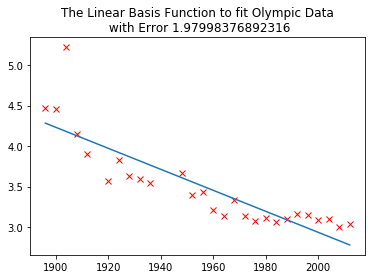

In [8]:
#### Question 1 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

import numpy as np
import pods
from matplotlib import pyplot as plt


def linear(x):
    '''
    the function computes _phi for the linear basis
    :param x: is in the form of `numpy` two dimensional array with n rows and 1 column
    :return: _phi, which is the form of a design matrix
    '''
    _phi = np.insert(x, 0, values=1, axis=1)
    return _phi


def prediction(w, x, linear):
    '''
    computer predictions
    :param w: parameter vector
    :param x: inputs (co-variates)
    :param linear: a python function that define a basis as well as a set of inputs and a vector of parameters
    :return: _f, a prediction, a two dimensional `numpy` array with n rows and 1 column,
     where n is the number of data points
    '''
    _f = (w.T * linear(x)).sum(axis=1)
    return _f


def objective(w, x, y, linear):
    '''
    computes the sum of squares objective function (error function)
    :param w: parameter vector
    :param x: inputs (co-variates)
    :param y: target data (response variables)
    :param linear: a python function that represents the basis
    :return: _e, the sum of squares objective
    '''
    minus = (w.T * linear(x)).sum(axis=1)
    delta = y - minus.reshape(y.shape)
    _e = np.dot(delta.T, delta).sum()
    return _e


def fit(x, y, linear):
    '''
    solves the linear system for the set of parameters that minimises the sum of squares objective
    :param x: inputs (co-variates)
    :param y: target data (response variables)
    :param linear: a python function that represents the basis
    :return: _w, parameter vector that minimises the sum of squares objective
    '''
    _w = np.linalg.solve(np.dot(linear(x).T, linear(x)), np.dot(linear(x).T, y))
    return _w


# call functions above and check their outputs
phi = linear(x)
print("phi", phi)
w = fit(x, y, linear)
print("w", w)
f = prediction(w, x, linear)
print("f", f)
e = objective(w, x, y, linear)
print("e", e)

# plot and check basis function
plt.plot(x, y, 'rx')
plt.plot(x, f)
plt.title("The Linear Basis Function to fit Olympic Data\n with Error {}".format(e))
plt.show()

## Polynomial Fit: Training Error

The next thing we'll do is consider a quadratic fit. We will compute the training error for the two fits.


### Assignment Question 2

In this question we extend the code above to a non-linear basis (a quadratic function).

Start by creating a python-function called `quadratic`. It should compute the quadratic basis.
$$\boldsymbol{\Phi} = \begin{bmatrix} \mathbf{1} & \mathbf{x} & \mathbf{x}^2\end{bmatrix}$$
It should be called in the following form:
```python
Phi = quadratic(x)
```
Use this to compute the quadratic fit for the model, again plotting the result titled by the error.

*10 marks*

phi [[1.000000e+00 1.896000e+03 3.594816e+06]
 [1.000000e+00 1.900000e+03 3.610000e+06]
 [1.000000e+00 1.904000e+03 3.625216e+06]
 [1.000000e+00 1.908000e+03 3.640464e+06]
 [1.000000e+00 1.912000e+03 3.655744e+06]
 [1.000000e+00 1.920000e+03 3.686400e+06]
 [1.000000e+00 1.924000e+03 3.701776e+06]
 [1.000000e+00 1.928000e+03 3.717184e+06]
 [1.000000e+00 1.932000e+03 3.732624e+06]
 [1.000000e+00 1.936000e+03 3.748096e+06]
 [1.000000e+00 1.948000e+03 3.794704e+06]
 [1.000000e+00 1.952000e+03 3.810304e+06]
 [1.000000e+00 1.956000e+03 3.825936e+06]
 [1.000000e+00 1.960000e+03 3.841600e+06]
 [1.000000e+00 1.964000e+03 3.857296e+06]
 [1.000000e+00 1.968000e+03 3.873024e+06]
 [1.000000e+00 1.972000e+03 3.888784e+06]
 [1.000000e+00 1.976000e+03 3.904576e+06]
 [1.000000e+00 1.980000e+03 3.920400e+06]
 [1.000000e+00 1.984000e+03 3.936256e+06]
 [1.000000e+00 1.988000e+03 3.952144e+06]
 [1.000000e+00 1.992000e+03 3.968064e+06]
 [1.000000e+00 1.996000e+03 3.984016e+06]
 [1.000000e+00 2.000000e+03 4.

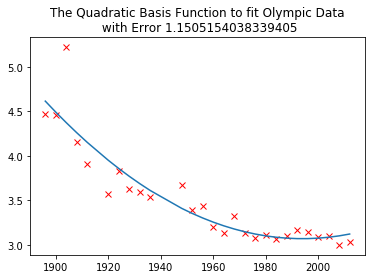

In [10]:
#### Question 2 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

def quadratic(x):
    '''
    the function computes _phi for the quadratic basis
    :param x: is in the form of `numpy` two dimensional array with n rows and 1 column
    :return: _phi, which is the form of a design matrix
    '''
    _phi = np.ones(shape=(x.shape[0], 3))
    for i in range(3):
        _phi[:, i: i + 1] = x ** i
    return _phi


def prediction(w, x, quadratic):
    '''
    computer predictions
    :param w: parameter vector
    :param x: inputs (co-variates)
    :param quadratic: a python function that define a basis as well as a set of inputs and a vector of parameters
    :return: _f, a prediction, a two dimensional `numpy` array with n rows and 1 column,
     where n is the number of data points
    '''
    _f = (w.T * quadratic(x)).sum(axis=1)
    return _f


def objective(w, x, y, quadratic):
    '''
    computes the sum of squares objective function (error function)
    :param w: parameter vector
    :param x: inputs (co-variates)
    :param y: target data (response variables)
    :param quadratic: a python function that represents the basis
    :return: _e, the sum of squares objective
    '''
    minus = (w.T * quadratic(x)).sum(axis=1)
    delta = y - minus.reshape(y.shape)
    _e = np.dot(delta.T, delta).sum()
    return _e


def fit(x, y, quadratic):
    '''
    solves the linear system for the set of parameters that minimises the sum of squares objective
    :param x: inputs (co-variates)
    :param y: target data (response variables)
    :param quadratic: a python function that represents the basis
    :return: _w, parameter vector that minimises the sum of squares objective
    '''
    _w = np.linalg.solve(np.dot(quadratic(x).T, quadratic(x)), np.dot(quadratic(x).T, y))
    return _w


# call functions above and check their outputs
phi = quadratic(x)
print("phi", phi)
w = fit(x, y, quadratic)
print("w", w)
f = prediction(w, x, quadratic)
print("f", f)
e = objective(w, x, y, quadratic)
print("e", e)
# plot and check basis function
plt.plot(x, y, 'rx')
plt.plot(x, f)
plt.title("The Quadratic Basis Function to fit Olympic Data\n with Error {}".format(e))
plt.show()

### Hold Out Data

You have a conclusion as to which model fits best under the training error, but how do the two models perform in terms of validation? In this section we consider *hold out* validation. In hold out validation we remove a portion of the training data for *validating* the model on. The remaining data is used for fitting the model (training). Because this is a time series prediction, it makes sense for us to hold out data at the end of the time series. This means that we are validating on future predictions. We will hold out data from after 1980 and fit the model to the data before 1980. 

In [9]:
# select indices of data to 'hold out'
indices_hold_out = np.flatnonzero(x>1980)

# Create a training set
x_train = np.delete(x, indices_hold_out, axis=0)
y_train = np.delete(y, indices_hold_out, axis=0)

# Create a hold out set
x_valid = np.take(x, indices_hold_out, axis=0)
y_valid = np.take(y, indices_hold_out, axis=0)

### Assignment Question 3

For both the linear and quadratic models, fit the model to the data up until 1980 and then compute the error on the held out data (from 1980 onwards). Which model performs better on the validation data?

*10 marks*

w_linear
 [[ 3.82810200e+01]
 [-1.78490871e-02]]
f_linear
 [4.43915081 4.36775446 4.29635811 4.22496176 4.15356542 4.01077272
 3.93937637 3.86798002 3.79658367 3.72518732 3.51099828 3.43960193
 3.36820558 3.29680923 3.22541288 3.15401654 3.08262019 3.01122384
 2.93982749 2.86843114 2.79703479 2.72563844 2.6542421  2.58284575
 2.5114494  2.44005305 2.3686567 ]
e_linear
 1.9115972528734302
w_quadratic
 [[ 8.46953830e+02]
 [-8.52546484e-01]
 [ 2.15348696e-04]]
f_quadratic
 [4.664633   4.52430166 4.39086147 4.26431245 4.14465458 3.92601232
 3.82702793 3.7349347  3.64973262 3.5714217  3.3778359  3.32708962
 3.28323449 3.24627052 3.21619772 3.19301606 3.17672557 3.16732624
 3.16481806 3.16920104 3.18047518 3.19864048 3.22369694 3.25564455
 3.29448333 3.34021326 3.39283435]
e_quadratic
 0.3375058139668411


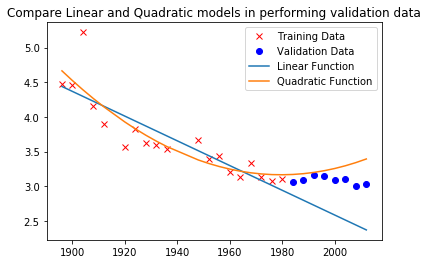


From the plot,
we can observe intuitively that the Quadratic Function curve is fitter for blue points (Validation data), 
and the objective of Linear Function is 1.9115972528734302, and the Quadratic Function is 0.3375058139668411.
That is e_linear > e_quadratic.
We could draw a conclusion that the quadratic model performs better on the validation data.



In [14]:
#### Question 3 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

# print result based on linear basis function
phi_linear = linear(x)
# print("phi_linear\n", phi_linear)
w_linear = fit(x_train, y_train, linear)
print("w_linear\n", w_linear)
f_linear = prediction(w_linear, x, linear)
print("f_linear\n", f_linear)
e_linear = objective(w_linear, x_valid, y_valid, linear)
print("e_linear\n", e_linear)

# print result based on quadratic basis function
phi_quadratic = quadratic(x)
# print("phi_quadratic\n", phi_quadratic)
w_quadratic = fit(x_train, y_train, quadratic)
print("w_quadratic\n", w_quadratic)
f_quadratic = prediction(w_quadratic, x, quadratic)
print("f_quadratic\n", f_quadratic)
e_quadratic = objective(w_quadratic, x_valid, y_valid, quadratic)
print("e_quadratic\n", e_quadratic)

# plot data
plt.plot(x_train, y_train, 'rx', label="Training Data")
plt.plot(x_valid, y_valid, 'bo', label="Validation Data")
plt.plot(x, f_linear, label="Linear Function")
plt.plot(x, f_quadratic, label="Quadratic Function")
plt.title("Compare Linear and Quadratic models in performing validation data")
plt.legend()
plt.show()

# draw a conclusion
result = '''
From the plot,
we can observe intuitively that the Quadratic Function curve is fitter for blue points (Validation data), 
and the objective of Linear Function is {}, and the Quadratic Function is {}.
That is e_linear > e_quadratic.
We could draw a conclusion that the quadratic model performs better on the validation data.
'''.format(e_linear, e_quadratic)
print(result)

### Richer Basis Set

Now we have an approach for deciding which model to retain, we can consider the entire family of polynomial bases, with arbitrary degrees.  

### Assignment Question 4

Now we are going to build a more sophisticated form of basis function, one that can accept arguments to its inputs (similar to those we used in the lab for week 4). Here we will start with a polynomial basis.

```python
def polynomial(x, degree, loc, scale):
    degrees = np.arange(degree+1)
    return ((x-loc)/scale)**degrees
```
The basis as we've defined it has three arguments as well as the input. The degree of the polynomial, the scale of the polynomial and the offset. These arguments need to be passed to the basis functions whenever they are called. Modify your code to pass these additional arguments to the python function for creating the basis. Do this for each of your functions `predict`, `fit` and `objective`. You will find `*args` (or `**kwargs`) useful.

Write code that tries to fit different models to the data with polynomial basis. Use a maximum degree for your basis from 0 to 17. For each polynomial store the *hold out validation error* and the *training error*. When you have finished the computation plot the hold out error for your models and the training error for your p. When computing your polynomial basis use `offset=1956.` and `scale=120.` to ensure that the data is mapped (roughly) to the -1, 1 range.

Which polynomial has the minimum training error? Which polynomial has the minimum validation error?

*25 marks*

train_err [6.318768491802087, 1.7689846469718613, 1.1176855951012825, 1.068749974567444, 1.0636894392804108, 1.0443062095877804, 0.8225486096605781, 0.6487877509101909, 0.6149943430650007, 0.6157985773271817, 0.6005389785312382, 0.5662352550500364, 0.4113856506373302, 0.2327673903521972, 0.1703576446913978, 0.1673154172412525, 0.15044405287875703, 0.10581802524922675]
valid_err [1.4032009947474668, 0.21099912195130033, 0.03282980873271851, 0.01512022388211188, 0.017284174896321194, 0.02766340530736135, 0.0479350549423886, 0.009435732246629074, 0.010050581590576087, 0.006175846489664957, 0.006329583509769114, 0.007755087520457732, 0.027126779115371147, 0.024608045251269337, 0.0007423546020363228, 0.001456798071889344, 0.0017608832969458698, 0.006137370415188257]


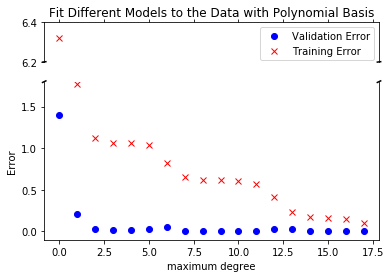


The 17 th polynomial has the minimum training error, which is 0.10581802524922675.
The 14 th polynomial has the minimum validation error, which is 0.0007423546020363228.



In [16]:
#### Question 4 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

import numpy as np
import pods
from matplotlib import pyplot as plt, gridspec


def polynomial(x, degree, loc, scale):
    '''
    a more sophisticated form of basis function
    :param x:
    :param degree: the degree of the polynomial
    :param loc: the offset of the polynomial
    :param scale: the scale of the polynomial
    :return: polynomial vector
    '''
    degrees = np.arange(degree + 1)
    # print(degrees)
    return ((x - loc) / scale) ** degrees


def prediction(w, x, polynomial, **kwargs):
    '''
    a modified prediction function
    :param w: parameter vector
    :param x: inputs
    :param polynomial: a python function that define a basis as well as a set of inputs and a vector of parameters
    :param kwargs: keyword arguments, including degree, location and scale
    :return: prediction values vector, _f
    '''
    degree = kwargs['degree']
    loc = kwargs['loc']
    scale = kwargs['scale']
    _f = (w.T * polynomial(x, degree, loc, scale)).sum(axis=1)
    return _f


def objective(w, x, y, polynomial, **kwargs):
    '''
    a modified objective function
    :param w: parameter vector
    :param x: inputs
    :param y: target vector
    :param polynomial: a python function that define a basis as well as a set of inputs and a vector of parameters
    :param kwargs: keyword arguments, including degree, location and scale
    :return: the sum of squares objective, _e
    '''
    degree = kwargs['degree']
    loc = kwargs['loc']
    scale = kwargs['scale']
#     print("test{}".format(degree), w.T * polynomial(x, degree, loc, scale),
#           (w.T * polynomial(x, degree, loc, scale)).shape)
    minus = (w.T * polynomial(x, degree, loc, scale)).sum(axis=1)
#     print("minus", minus, minus.shape)
    delta = y - minus.reshape(y.shape)
#     print("y - minus", delta, delta.shape)
#     print("e", delta ** 2, np.dot(delta.T, delta).shape)
    _e = (delta ** 2).sum()
    return _e


def fit(x, y, polynomial, **kwargs):
    '''
    a modified fit function
    :param x: inputs
    :param y: target vector
    :param polynomial: a python function that define a basis as well as a set of inputs and a vector of parameters
    :param kwargs: keyword arguments, including degree, location and scale
    :return: parameter vector, _w
    '''
    degree = kwargs['degree']
    loc = kwargs['loc']
    scale = kwargs['scale']
    _w = np.linalg.solve(
        np.dot(
            polynomial(x, degree, loc, scale).T,
            polynomial(x, degree, loc, scale)
        ),
        np.dot(polynomial(x, degree, loc, scale).T, y)
    )
    return _w


# store validation error with different models of different polynomial degrees into an array
validation_err = []
# store training error with different models of different polynomial degree into an array
train_err = []
# store index
index = []
for i in range(18):
    index.append(i)
    kw = dict(
        degree=i,
        loc=1956,
        scale=120
    )
#     print(polynomial(x_train, kw["degree"], kw["loc"], kw["scale"]))
    w = fit(x, y, polynomial, **kw)
#     print(w)
    e_valid = objective(w, x_valid, y_valid, polynomial, **kw)
#     print("e_valid", e_valid)
    validation_err.append(e_valid)
    e_train = objective(w, x_train, y_train, polynomial, **kw)
#     print("e_train", e_train)
    train_err.append(e_train)

print("train_err", train_err)
print("valid_err", validation_err)

# plot data
fig = plt.figure()
# set height ratios of figures
heights = [1, 4]
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=heights)
ax2 = fig.add_subplot(spec[0, 0])
ax = fig.add_subplot(spec[1, 0])

# set title
# plt.title("Fit Different Models to the Data with Polynomial Basis")
ax2.set_title("Fit Different Models to the Data with Polynomial Basis")

ax.plot(index, validation_err, 'bo', label="Validation Error")
ax2.plot(index, validation_err, 'bo', label="Validation Error")

ax.plot(index, train_err, 'rx', label="Training Error")
ax2.plot(index, train_err, 'rx', label="Training Error")

# set y limit views
ax.set_ylim(-0.1, 1.8)
ax2.set_ylim(6.2, 6.4)

# hide spines of figures
ax.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# set location of x tick
ax.xaxis.tick_bottom()
ax2.xaxis.tick_top()
ax2.tick_params(labeltop=False)

plt.xlabel("maximum degree")
plt.ylabel("Error")

# make the diagonal lines in axes coordinates
d = 0.005
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# btm left
ax.plot((-d, +d), ((1 - d), (1 + d)), **kwargs)
# btm right
ax.plot(((1 - d), (1 + d)), ((1 - d), (1 + d)), **kwargs)
kwargs.update(transform=ax2.transAxes)
# top left
ax2.plot((-d, +d), (-d, +d), **kwargs)
# top right
ax2.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax2.legend()
plt.show()


# print conclusion
result = '''
The {} th polynomial has the minimum training error, which is {}.
The {} th polynomial has the minimum validation error, which is {}.
'''.format(
    train_err.index(min(train_err)),
    min(train_err),
    validation_err.index(min(validation_err)),
    min(validation_err)
)
print(result)

In [17]:
train_err

[6.318768491802087,
 1.7689846469718613,
 1.1176855951012825,
 1.068749974567444,
 1.0636894392804108,
 1.0443062095877804,
 0.8225486096605781,
 0.6487877509101909,
 0.6149943430650007,
 0.6157985773271817,
 0.6005389785312382,
 0.5662352550500364,
 0.4113856506373302,
 0.2327673903521972,
 0.1703576446913978,
 0.1673154172412525,
 0.15044405287875703,
 0.10581802524922675]

## Leave One Out Validation

Hold out validation uses a portion of the data to hold out and a portion of the data to train on. There is always a compromise between how much data to hold out and how much data to train on. The more data you hold out, the better the estimate of your performance at 'run-time' (when the model is used to make predictions in real applications). However, by holding out more data, you leave less data to train on, so you have a better validation, but a poorer quality model fit than you could have had if you'd used all the data for training. Leave one out cross validation leaves as much data in the training phase as possible: you only take *one point* out for your validation set. However, if you do this for hold-out validation, then the quality of your validation error is very poor because you are testing the model quality on one point only. In *cross validation* the approach is to improve this estimate by doing more than one model fit. In *leave one out cross validation* you fit $n$ different models, where $n$ is the number of your data. For each model fit you take out one data point, and train the model on the remaining $n-1$ data points. You validate the model on the data point you've held out, but you do this $n$ times, once for each different model. You then take the *average* of all the $n$ badly estimated hold out validation errors. The average of this estimate is a good estimate of performance of those models on the test data. 

### Assignment Question 5

Write code that computes the *leave one out* validation error for the olympic data and the polynomial basis. Use the functions you have created above: `objective`, `fit`, `polynomial`. Compute the *leave-one-out* cross validation error for basis functions containing a maximum degree from 0 to 17.

*20 marks*

leave_one_out_validation_err
max degree: 0, leave one out validation error: 0.3084218581905887
max degree: 1, leave one out validation error: 0.09060070816797523
max degree: 2, leave one out validation error: 0.05794992394529426
max degree: 3, leave one out validation error: 0.05980705068471014
max degree: 4, leave one out validation error: 0.06927418752471903
max degree: 5, leave one out validation error: 0.08836110587080025
max degree: 6, leave one out validation error: 0.08192830192027423
max degree: 7, leave one out validation error: 0.05811513386609621
max degree: 8, leave one out validation error: 0.12260215748822542
max degree: 9, leave one out validation error: 0.37178792649168857
max degree: 10, leave one out validation error: 1.0449075851256693
max degree: 11, leave one out validation error: 2.5644046541786025
max degree: 12, leave one out validation error: 5.459390476750223
max degree: 13, leave one out validation error: 8.319010643336494
max degree: 14, leave one out valida

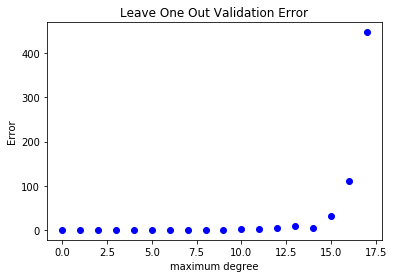

In [22]:
#### Question 5 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

def cross_validation(degree):
    '''
    compute the leave-one-out cross validation error for basis functions containing a maximum degree from 0 to 17
    :param degree: maximum degree
    :return: an array of validation error
    '''
    err = 0
    for i in range(x.shape[0]):
        # select indices of data to 'hold out'
        indices_hold_out = [i]
#         print("indices_hold_out", indices_hold_out)

        # Create a training set
        x_train = np.delete(x, indices_hold_out, axis=0)
        y_train = np.delete(y, indices_hold_out, axis=0)
        # print("x_train", x_train)
        # print(y_train)

        # Create a hold out set
        x_valid = np.take(x, indices_hold_out, axis=0)
        y_valid = np.take(y, indices_hold_out, axis=0)
        # print("x_valid", x_valid)
        # print(y_valid)

        kw = dict(
            degree=degree,
            loc=1956,
            scale=120
        )
        w = fit(x_train, y_train, polynomial, **kw)
        e = objective(w, x_valid, y_valid, polynomial, **kw)
        err = err + e
    return err / x.shape[0]


# store validation error with different models of different polynomial degrees into an array
leave_one_out_validation_err = []
# train_err = []
index = []
for i in range(18):
#     print(i)
    index.append(i)
    degree = i
    e_valid = cross_validation(degree)
#     print("e_valid", e_valid)
    leave_one_out_validation_err.append(e_valid)

# print calculation result
print("leave_one_out_validation_err")
for i in range(len(leave_one_out_validation_err)):
    print("max degree: {}, leave one out validation error: {}".format(i, leave_one_out_validation_err[i]))

# plot data
plt.plot(index, leave_one_out_validation_err, 'bo')
plt.title("Leave One Out Validation Error")
plt.xlabel("maximum degree")
plt.ylabel("Error")
plt.show()

## $k$-fold Cross Validation

Leave one out cross validation produces a very good estimate of the performance at test time, and is particularly useful if you don't have a lot of data. In these cases you need to make as much use of your data for model fitting as possible, and having a large hold out data set (to validate model performance) can have a significant effect on the size of the data set you have to fit your model, and correspondingly, the complexity of the model you can fit. However, leave one out cross validation involves fitting $n$ models, where $n$ is your number of training data. For the olympics example, this is only 27 model fits, but in practice many data sets consist thousands or millions of data points, and fitting many millions of models for estimating validation error isn't really practical. One option is to return to *hold out* validation, but another approach is to perform $k$-fold cross validation. In $k$-fold cross validation you split your data into $k$ parts. Then you use $k-1$ of those parts for training, and hold out one part for validation. Just like we did for the hold out validation above. In *cross* validation, however, you repeat this process. You swap the part of the data you just used for validation back in to the training set and select another part for validation. You then fit the model to the new training data and validate on the portion of data you've just extracted. Each split of training/validation data is called a *fold* and since you do this process $k$ times, the procedure is known as $k$-fold cross validation. The term *cross* refers to the fact that you cross over your validation portion back into the training data every time you perform a fold.  

### Assignment Question 6

Perform $k$-fold cross validation on the olympic data with your polynomial basis. Use $k$ set to 5 (e.g. five fold cross validation). Do the different forms of validation select different models? Does five fold cross validation always select the same model?

*20 marks*

*Note*: The data doesn't divide into 5 equal size partitions for the five fold cross validation error. Don't worry about this too much. Two of the partitions will have an extra data point. You might find `np.random.permutation?` useful.

k_cross_validation_err
max degree: 0, k-cross validation error: 1.7210450563018374
max degree: 1, k-cross validation error: 0.45991890285172216
max degree: 2, k-cross validation error: 0.32541932386834593
max degree: 3, k-cross validation error: 0.32910473777779503
max degree: 4, k-cross validation error: 0.27706052021406186
max degree: 5, k-cross validation error: 0.41144314528348386
max degree: 6, k-cross validation error: 0.3810723034683494
max degree: 7, k-cross validation error: 0.3284285329457874
max degree: 8, k-cross validation error: 0.3883955743202031
max degree: 9, k-cross validation error: 2.4352376304013683
max degree: 10, k-cross validation error: 11.770972853310933
max degree: 11, k-cross validation error: 11.972539568626203
max degree: 12, k-cross validation error: 28.200922593478804
max degree: 13, k-cross validation error: 4547.520992831812
max degree: 14, k-cross validation error: 92.21904769127384
max degree: 15, k-cross validation error: 319.3771810807441
max degre

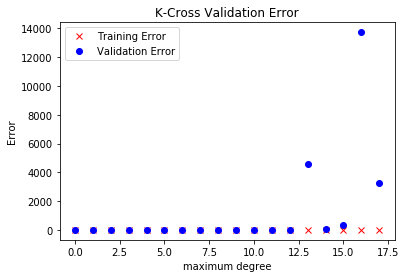


The 16 th polynomial has the minimum training error, which is 0.03749909752929466.
The 4 th polynomial has the minimum validation error, which is 0.27706052021406186.
The different forms of validation select different models.
Five fold cross validation does not always select the same model.



In [42]:
#### Question 6 Answer Code
# Write code for you answer to this question in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.

def rearrange_data(data_x, data_y):
    '''
    rearrange data set with a random order, and make sure the data in new data_x maps to the data in new data_y
    :param data_x:
    :param data_y:
    :return: a tuple contains rearranged index, data_x and data_y
    '''
#     for i in range(len(data_x)):
#         print("{}, {}".format(i, data_x[i]))
    random_index = np.random.permutation(np.arange(0, len(data_x)))
#     print("random_index", random_index, len(random_index))
    random_x = np.array([])
    random_y = np.array([])
    for i in range(len(random_index)):
        random_x = np.insert(random_x, i, data_x[random_index[i]], axis=0)
        random_y = np.insert(random_y, i, data_y[random_index[i]], axis=0)

#     print("random_x", random_x)
#     print("random_y", random_y)
    return random_index, random_x, random_y


def pack_folders(arr, k):
    '''
    divide data in an array into k partitions, and make sure each folder has similar number of data
    :param arr: the data set
    :param k: number of folders
    :return: an array contains multiple tuples of array indexes
    '''
    tmp = int(len(arr) / k)
    rem = len(arr) % k
    result = []
    index = 0
    for i in range(k):
#         print("i", i)
#         print("i * tmp", i * tmp)
#         print("(i + 1) * tmp", (i + 1) * tmp)
        if i >= k - rem and rem != 0:
#             print(arr[index: index + tmp + 1])
            result.append((index, index + tmp + 1))
            index = index + tmp + 1
#             print("index", index)
        else:
            index = index + tmp
#             print(arr[i * tmp: (i + 1) * tmp])
#             print("index", index)
            result.append((i * tmp, index))
    return result


def k_cross_validation(data_x, data_y, k, polynomial, degree):
    '''
    perform k -fold cross validation on data with polynomial basis
    :param data_x: inputs
    :param data_y: targets
    :param k: number of divisions
    :param polynomial: polynomial basis function
    :param degree: the maximum degree of a polynomial basis function
    :return: average validation error on each cross-validation folder
    '''
    rand_index, rand_x, rand_y = rearrange_data(data_x, data_y)
    folders = pack_folders(rand_index, k)
    e_train_sum = 0
    e_valid_sum = 0
    for i in range(len(folders)):
        # select indexes of data to 'hold out'
        ran = np.arange(folders[i][0], folders[i][1])
        # select indices of data to 'hold out'
        arr_x_valid = rand_x[folders[i][0]: folders[i][1]]
#         print("arr_x_valid", arr_x_valid)
        # Create a training set
        arr_x_train = np.delete(rand_x, ran, axis=0)
#         print("arr_x_train", arr_x_train, arr_x_train.shape)
        arr_y_valid = rand_y[folders[i][0]: folders[i][1]]
        arr_y_train = np.delete(rand_y, ran, axis=0)
        kw = dict(
            degree=degree,
            loc=1956,
            scale=120
        )
        # print(polynomial(arr_x_train.reshape(arr_x_train.shape[0], 1), 2, 1956, 120))
        w = fit(
            arr_x_train.reshape(arr_x_train.shape[0], 1),
            arr_y_train.reshape(arr_x_train.shape[0], 1),
            polynomial,
            **kw
        )
        e_train = objective(
            w,
            arr_x_train.reshape(arr_x_train.shape[0], 1),
            arr_y_train.reshape(arr_y_train.shape[0], 1),
            polynomial,
            **kw
        )
        e_valid = objective(
            w,
            arr_x_valid.reshape(arr_x_valid.shape[0], 1),
            arr_y_valid.reshape(arr_y_valid.shape[0], 1),
            polynomial,
            **kw
        )
#         print(e_valid)
        e_train_sum = e_train_sum + e_train
        e_valid_sum = e_valid_sum + e_valid
    return (e_train_sum / k, e_valid_sum / k)


k_cross_train_err = []
k_cross_validation_err = []
index_degree = []
for i in range(18):
#     print(i)
    index_degree.append(i)
    degree = i
    e_train_final, e_valid_final = k_cross_validation(x, y, 5, polynomial, degree)
    k_cross_train_err.append(e_train_final)
    k_cross_validation_err.append(e_valid_final)


# print calculation result
print("k_cross_validation_err")
for i in range(len(k_cross_validation_err)):
    print("max degree: {}, k-cross validation error: {}".format(i, k_cross_validation_err[i]))


# plot data
plt.plot(index_degree, k_cross_train_err, 'rx', label="Training Error")
plt.plot(index_degree, k_cross_validation_err, 'bo', label="Validation Error")
plt.title("K-Cross Validation Error")
plt.xlabel("maximum degree")
plt.ylabel("Error")
plt.legend()
plt.show()

# print conclusion
conclusion = '''
The {} th polynomial has the minimum training error, which is {}.
The {} th polynomial has the minimum validation error, which is {}.
The different forms of validation select different models.
Five fold cross validation does not always select the same model.
'''.format(
    k_cross_train_err.index(min(k_cross_train_err)),
    min(k_cross_train_err),
    k_cross_validation_err.index(min(k_cross_validation_err)),
    min(k_cross_validation_err)
)
print(conclusion)